In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import time
import sys
import warnings
warnings.filterwarnings('ignore')

# Books Dataset

We only extract the information we are interested in books dataset. ( s.t. ISBN, Title, Author, Year of Publication, Publisher).

In [2]:
def getBookDataset():
    books = pd.read_csv("BX-CSV-Dump/BX-Books.csv",sep="delimiter",engine='python')
    books.iloc[:,0] = books.iloc[:,0].apply(lambda x: x.split(";")[:-3])
    # reset the index as ISBN
    book_idx = [i[0].replace('"', '') for i in books.iloc[:,0].tolist()]
    book_idxSet = set(book_idx)
    books.index = book_idx
    # reset the header
    books.columns = ["Title"]
    # reset the content
    books["Author"] = books["Title"].apply(lambda x: x[2].replace('"', ''))
    books["Year of Publication"] = books["Title"].apply(lambda x: x[3].replace('"', ''))
    books["Publisher"] = books["Title"].apply(lambda x: x[4].replace('"', ''))
    books["Title"] = books["Title"].apply(lambda x: x[1].replace('"', ''))
    return books

books = getBookDataset()
books.head()

,Title,Author,Year of Publication,Publisher
0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp


# Users Dataset
Explores user's dataset.

In [3]:
def getUserDataset():
    def replaceAge(x):
        if x == "NULL":
            return 0
        else:
            return int(x[1:-1])

    users = pd.read_csv("BX-CSV-Dump/BX-Users.csv",sep="delimiter",engine='python')
    users.columns = ["Location"]
    # reset Age
    users["Age"] = users["Location"].apply(lambda x: replaceAge(x.split(";")[-1]))
    average_age = float(round(sum(users["Age"].tolist())/len(users)))
    users["Age"] = users["Age"].apply(lambda x: average_age if x == 0 else x)
    # reset index as user ID
    user_idx = [int(i.split(";")[0].replace('"', '')) for i in users.iloc[:,0].tolist()]
    user_idxSet = set(user_idx)
    users.index = user_idx
    # reset location
    users["Location"] = users["Location"].apply(lambda x: x.split(";")[1].split(",")[-1].replace('"', ''))
    return users

users = getUserDataset()
users.head()

,Location,Age
1,usa,21.0
2,usa,18.0
3,russia,21.0
4,portugal,17.0
5,united kingdom,21.0


# Ratings Dataset
## We extract the ratings from the rating dataset. 
There are a lot of error data in the rating dataset.

For example
 1. if the value of rating is 0, we think it is meaningless.
 2. Some ISBN in the rating dataset does not appear in the books dataset, we also think it is meaningless.

By cleaning up the data, we end up with clean data that we can use to operate.

In [4]:
def getBookRatings():
    bookRatings = pd.read_csv("BX-CSV-Dump/BX-Book-Ratings.csv",sep="delimiter",engine="python")
    bookRatings.columns = ["User-ID"]
    bookRatings["ISBN"] = bookRatings["User-ID"].apply(lambda x: x.split(";")[1].replace('"', ''))
    bookRatings["Rating"] = bookRatings["User-ID"].apply(lambda x: int(x.split(";")[-1].replace('"', '').replace(",","")))
    bookRatings["User-ID"] = bookRatings["User-ID"].apply(lambda x: x.split(";")[0].replace('"', ''))
    # drop the column which ISBN not exist
    ratingToDrop = bookRatings[bookRatings["ISBN"].apply(lambda x: not x in books.index)].index
    bookRatings = bookRatings.drop(ratingToDrop)
    # drop the column which rating is 0
    ratingToDrop = bookRatings[bookRatings["Rating"].apply(lambda x: x == 0)].index
    bookRatings = bookRatings.drop(ratingToDrop)
    bookRatings.head(10)
    return bookRatings

bookRatings = getBookRatings()
bookRatings.head(5)

,User-ID,ISBN,Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


## We can get the overview about the distribution of book ratings.

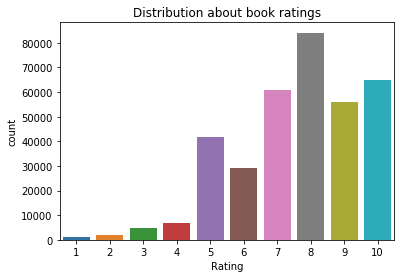

In [5]:
sns.countplot(data=bookRatings, x="Rating")
plt.title("Distribution about book ratings")
plt.show()

# Collaborative Filtering based Recommendation System

### Funtions used for CF-based recommendation systems
in order to speed up the operation of the program, we only consider users who have rated at least 50 books and books which have at least 50 ratings.

In [6]:
# functions for generating user-item ratings matrix
def generateUserBooksMatrix(bookRatings, userRatingBounds=50, bookRatingBounds=50):
    bookCounts = bookRatings["ISBN"].value_counts()
    userCounts = bookRatings["User-ID"].value_counts()
    # only keep the user and book which has over 100 ratings.
    userCounts = userCounts[userCounts >= userRatingBounds]
    bookCounts = bookCounts[bookCounts >= bookRatingBounds]

    newBookRating = bookRatings[bookRatings["ISBN"].isin(bookCounts.index)]
    newBookRating = newBookRating[newBookRating["User-ID"].isin(userCounts.index)]

    ubMatrix = newBookRating.pivot(index="User-ID", columns="ISBN", values="Rating")
    ubMatrix = ubMatrix.fillna(0)
    ubMatrix = ubMatrix.drop_duplicates()
    return ubMatrix

# similarity function
def cosSimilarity(matrix, df, userId):
    vector = pd.DataFrame(index=[userId],columns=matrix.index)
    pb = df.loc[userId].tolist()
    pb_mag = np.sqrt(sum([j**2 for j in pb]))
    for idx in matrix.index:
        if idx == userId:
            continue
        pa = matrix.loc[idx].tolist()
        sim = np.dot(pa,pb)/(np.sqrt(sum([i**2 for i in pa]))*pb_mag)
        vector[idx] = sim
    return vector




# User-Based Collaborative Filtering

Here we recommend books for a user whose ID is "6575". You can change any ID which occurs in the database.

It is better to choose the user who have rated more than 50 books.


In [7]:
# find similar user of given userId
def findSimilarUser(userId, matrix, original_matrix=bookRatings, algorithm="cos"):

    # get User Vector
    userVector = original_matrix[original_matrix["User-ID"].isin([userId])]
    user_books = userVector["ISBN"].tolist()
    df = pd.DataFrame(index=[userId],columns=matrix.columns)
    valid_df = userVector[userVector["ISBN"].isin(df.columns)]
    df[valid_df["ISBN"]] = valid_df["Rating"].tolist()
    df = df.fillna(0)
    
    
    if sorted(df.loc[userId].tolist(), reverse=True)[0] == 0:
        return df, df
    # add it into the matrix.
    matrix = pd.concat([matrix, df])
    matrix = matrix.drop_duplicates()
    
    # compute similarity.
    if algorithm == "cos":
        simVector = cosSimilarity(matrix, df, userId)
    if algorithm == "correlation":
        mat = pd.DataFrame(matrix, copy = True)
        mat.replace(0, np.nan, inplace = True)
        mat['user_mean'] = mat.mean(axis = 1)
        mat.iloc[:,:-1] = mat.iloc[:,:-1].sub(mat['user_mean'], axis=0)
        mat.replace(np.nan,0, inplace = True)
        mat.drop(columns = 'user_mean', inplace = True)
        simVector = cosSimilarity(mat, mat.loc[[userId]], userId)
        
        
    # find top-n similar user
    simVector = simVector.sort_values(userId,axis=1,ascending=False)#.iloc[:, :topSimilar]
    return simVector, df

# rating vector of user, learning Matrixs, books dataframe.
def recommendBooksForUser(userVector, simVector, matrix, numberOfBooks=10,topSimilar=5):
    sim_usersMatrix = matrix.loc[simVector.columns.tolist()]
    l = dict()
    for col in userVector.columns:
        if userVector[col].values[0] == 0:
            # calculate the aggregration
            simlist = simVector.columns.tolist()
            weightSum = 0
            weight = 0
            count = 0
            for uid in simlist:
                if count == topSimilar:
                    break
                ratingUI = sim_usersMatrix.loc[uid,col]
                if ratingUI == 0:
                    continue
                count += 1
                simUI = simVector[uid].values[0]
                weightSum += ratingUI*simUI
                weight += simUI
            if weight == 0:
                l[col] = 0
            else:
                pvalue = weightSum/weight
                if pvalue < 0:
                    l[col] = 0
                elif pvalue > 10:
                    l[col] = 10
                else:
                    l[col] = pvalue
    return l

# Recommend 10 books for a user by given ID.
def user_basedCF(uid, alg, topSim,ubMatrix):
    simVector, userVector = findSimilarUser(uid, algorithm=alg,matrix=ubMatrix)
    if sorted(userVector.loc[uid].tolist(), reverse=True)[0] == 0:
        print("This user do not have valid data in our user-item matrix:")
        sys.exit()
    
    outputdic = recommendBooksForUser(userVector, simVector,matrix=ubMatrix,topSimilar=topSim)
    outbooks = sorted(outputdic, key=lambda x: outputdic[x], reverse=True)[:10]

    return outbooks


#### 1. Get the user-item rating matrix. 
You can reduce the value of the parameter to increase the amount of data, which will improve the accuracy of the recommendation, but will increase the operation time.
#### 2. Calculate similarity between users.
you can choose the algorithm to use ("cos", "correlation")
#### 3. Recommend books.
you can modify the number of books you want to recommend to user.

#### 4. Please to choose the user in this list
['100459', '100846', '100906', '101209', '101305', '101606', '101851', '101876', '102275', '102647', '102702', '102967', '10314', '10354', '103541', '104113', '104144', '104399', '104429', '10447', '104636', '104665', '105028', '105374', '105517', '10560', '105979', '106007', '106225', '106280', '106849', '107301', '107784', '107951', '108352', '108405', '108799', '109461', '109574', '109779', '109901', '109955', '110029', '110373', '110912', '110934', '110973', '111174', '111578', '111944', '112001', '112083', '112093', '113270', '113519', '113955', '113983', '114178', '114368', '114414', '114444', '114544', '114868', '114988', '115003', '115435', '115490', '115572', '115692', '11601', '116758', '11676', '11687', '117251', '117384', '117873', '118533', '119575', '119858', '11993', '120093', '120396', '120598', '12100', '121170', '121606', '122429', '122716', '122793', '123056', '123094', '123095', '123257', '123544', '123597', '123608', '123981', '124078', '124310', '124487', '124597', '124876', '125039', '125203', '125287', '12538', '125519', '125774', '126196', '126492', '126604', '126693', '126736', '126814', '127129', '127233', '127359', '128085', '12824', '128696', '128835', '129074', '129084', '129716', '12982', '129851', '130474', '130482', '130554', '130571', '130705', '130847', '131126', '131402', '131855', '132375', '132663', '13273', '133296', '133571', '133689', '133747', '134434', '134797', '134837', '135045', '135149', '135265', '135351', '135360', '135458', '13552', '135609', '13582', '136010', '136139', '136205', '136252', '136348', '136382', '136491', '137190', '137589', '137688', '138198', '138441', '13850', '138543', '138578', '138602', '138844', '139828', '139913', '140000', '141444', '141493', '141710', '141819', '141902', '142121', '142256', '1424', '142479', '142524', '143163', '143175', '143253', '143415', '143968', '144038', '14422', '144531', '14456', '145109', '14521', '145449', '145641', '146113', '146230', '146348', '146803', '147451', '147847', '147965', '148199', '148258', '148744', '148898', '149069', '149908', '149934', '15049', '150896', '150968', '150979', '152186', '152946', '153054', '153662', '153718', '15408', '15418', '154345', '154469', '154529', '154992', '155014', '155147', '155219', '156150', '156214', '156269', '156300', '156467', '157247', '157273', '157811', '158226', '158295', '158433', '158606', '159033', '159506', '159732', '159834', '159858', '160295', '160401', '160558', '160681', '160819', '161041', '16106', '162052', '162639', '162738', '163202', '163307', '163570', '163804', '163973', '164096', '164323', '164675', '164926', '165183', '165308', '165319', '166123', '16634', '166596', '167471', '167800', '16795', '168047', '168064', '168245', '169663', '169682', '169779', '17003', '170513', '170634', '170724', '170947', '171118', '171295', '171602', '171970', '172030', '172061', '172742', '172760', '173291', '1733', '173415', '173679', '174092', '174216', '174304', '174326', '174596', '174830', '174848', '174892', '175052', '17667', '177072', '177374', '177375', '177432', '177458', '178199', '178522', '178667', '178920', '179019', '179288', '179433', '17950', '179718', '179730', '179734', '179772', '179791', '179826', '180348', '180651', '181176', '181687', '182085', '182993', '183046', '183187', '183196', '183995', '184279', '184299', '184365', '184401', '184424', '184513', '184532', '185176', '185233', '185384', '185634', '186570', '187065', '187145', '187256', '187517', '187762', '188010', '188027', '188171', '189080', '189139', '189334', '189392', '189516', '189835', '189973', '190708', '190741', '19085', '190885', '190925', '191716', '193458', '193499', '193529', '193778', '193898', '194600', '194676', '195374', '195694', '195904', '196077', '196160', '196502', '19664', '196738', '19711', '197364', '197659', '197687', '198012', '198930', '199416', '199772', '200226', '20060', '201017', '201042', '201290', '201526', '201684', '20172', '201768', '201969', '20201', '202277', '203017', '203240', '2033', '203799', '203910', '204359', '204457', '204591', '204864', '205473', '205735', '205980', '206074', '206202', '206219', '206534', '206563', '206567', '207246', '207349', '207494', '207499', '207616', '207782', '207825', '208019', '208141', '208406', '208671', '208829', '209160', '209373', '209464', '209516', '209756', '209875', '210035', '21014', '210485', '210959', '2110', '211344', '211426', '211919', '212923', '213150', '213316', '213628', '214786', '21576', '215986', '215988', '216012', '216444', '216466', '21659', '216683', '217121', '217318', '217740', '218121', '218552', '218568', '218608', '219321', '219546', '219683', '220240', '220597', '220688', '221445', '221732', '221753', '222035', '222204', '222296', '223087', '223154', '223190', '223231', '223501', '223787', '224138', '224349', '224430', '224646', '224764', '224809', '224997', '225087', '225199', '225232', '225379', '225595', '225763', '225886', '225986', '22625', '226545', '226879', '226965', '227447', '227520', '2276', '227705', '228021', '228681', '228764', '228998', '229011', '229313', '229329', '229409', '229551', '229741', '230013', '230522', '231210', '231237', '231393', '231827', '231857', '232131', '232945', '232964', '233711', '233911', '234359', '234597', '234721', '234828', '235105', '235282', '235392', '23571', '235935', '236058', '236283', '236340', '236757', '236959', '237271', '237534', '23768', '237990', '238120', '238699', '23872', '238781', '238889', '23902', '239423', '239584', '239594', '239626', '240035', '240144', '240219', '240401', '240403', '240567', '240568', '240700', '241204', '241548', '241565', '241666', '24194', '241980', '242083', '242106', '242299', '243077', '243294', '243328', '243360', '243700', '243929', '243930', '244171', '244420', '244627', '244662', '244685', '245295', '245371', '245410', '245645', '245827', '246156', '246247', '246311', '246513', '247129', '247447', '247852', '248221', '248477', '248718', '24933', '249628', '249862', '249894', '250300', '250405', '250709', '254', '25409', '25601', '25981', '26544', '26593', '27472', '27617', '27647', '2766', '277427', '278137', '27875', '28177', '28204', '28591', '28634', '2891', '28938', '29259', '29526', '2977', '30276', '30487', '30511', '30533', '30711', '30735', '31315', '31391', '31393', '31556', '31826', '32440', '32627', '32721', '32773', '33124', '33580', '3363', '33818', '33974', '34300', '35836', '35857', '35859', '36256', '36327', '36606', '36609', '36715', '36907', '37208', '37538', '37644', '37712', '37950', '38023', '3827', '38273', '38281', '38556', '39281', '39467', '39616', '39773', '4017', '40889', '40943', '41084', '41455', '41841', '43246', '43842', '43910', '44252', '44893', '46398', '46443', '46909', '47316', '47971', '48025', '48355', '48494', '49212', '49460', '50225', '50895', '51450', '51742', '51883', '51992', '52044', '52199', '52350', '52584', '52853', '52917', '53174', '53220', '55178', '55187', '55490', '55492', '55493', '55548', '5582', '55892', '55927', '56399', '56447', '56554', '56856', '56959', '57234', '58363', '58594', '59172', '59269', '60244', '60337', '60707', '6073', '61028', '61038', '61427', '61854', '61901', '6242', '6251', '62862', '62891', '6323', '63394', '638', '63956', '64241', '65258', '6543', '65584', '6563', '6575', '66680', '66942', '67547', '67663', '67840', '68185', '68249', '68436', '68555', '68760', '69078', '69156', '69211', '69355', '69378', '69389', '69684', '69971', '70183', '70415', '70594', '70666', '7125', '7158', '71712', '72214', '7286', '73330', '7346', '73588', '73651', '73681', '73923', '74026', '75081', '75591', '75819', '76151', '76223', '76352', '76483', '76499', '76626', '76818', '77480', '77809', '78448', '78553', '78783', '78834', '78973', '7915', '79266', '79441', '80538', '80555', '8066', '8067', '80810', '80945', '81492', '81597', '81848', '81977', '82407', '8245', '82497', '8253', '83287', '83637', '83671', '84024', '8454', '85426', '85526', '85656', '85757', '85993', '86145', '86189', '86243', '86392', '86720', '8681', '86835', '87141', '87555', '87712', '87938', '87964', '88229', '88283', '88677', '88693', '88733', '88793', '89602', '91113', '91184', '91342', '92498', '92547', '92810', '92861', '92979', '93047', '93092', '93179', '93363', '93426', '93565', '93629', '9417', '94242', '94347', '94853', '94923', '94951', '94985', '95316', '95359', '95903', '95932', '95991', '96357', '96448', '97324', '97754', '97874', '98263', '98391', '98547', '9856', '98686', '98758', '98787', '98904', '99955']

#### Result of using UBCF with Pearson Correlation Similarity

In [8]:
stime = time.time()
ubMatrix = generateUserBooksMatrix(bookRatings,50,50)
ubMatrix = ubMatrix[ubMatrix.nunique(axis=1)!=2]
outbooks = user_basedCF("6575","correlation",10,ubMatrix)
print(f"It Takes {time.time()-stime}s")
print("Here is the 10 books we recommend for you:")
books.loc[outbooks]


It Takes 2.3675639629364014s
Here is the 10 books we recommend for you:


,Title,Author,Year of Publication,Publisher
0446679593,Suzanne's Diary for Nicholas,James Patterson,2002,Warner Books
0451203771,Scarlet Feather,Maeve Binchy,2002,Signet Book
0515135062,Three Fates,Nora Roberts,2004,Jove Books
0553574574,Beach Music,Pat Conroy,1996,Bantam Books
0743203631,Gap Creek: The Story Of A Marriage,Robert Morgan,2000,Touchstone
0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey
080213825X,Four Blondes,Candace Bushnell,2001,Grove Press
0553274295,Where the Red Fern Grows,Wilson Rawls,1984,Random House Children's Books
0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey
0440414806,Holes (Yearling Newbery),LOUIS SACHAR,2000,Yearling


#### Result of using UBCF with Cosine Similarity

In [9]:
stime = time.time()
ubMatrix = generateUserBooksMatrix(bookRatings,50,50)
ubMatrix = ubMatrix[ubMatrix.nunique(axis=1)!=2]
outbooks = user_basedCF("6575","cos",10,ubMatrix)
print(f"It Takes {time.time()-stime}s")
print("Here is the 10 books we recommend for you:")
books.loc[outbooks]

It Takes 2.6061041355133057s
Here is the 10 books we recommend for you:


,Title,Author,Year of Publication,Publisher
059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp
0553274295,Where the Red Fern Grows,Wilson Rawls,1984,Random House Children's Books
0142004235,East of Eden (Oprah's Book Club),John Steinbeck,2003,Penguin Books
0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey
0345361792,A Prayer for Owen Meany,John Irving,1990,Ballantine Books
0064400557,Charlotte's Web (Trophy Newbery),E. B. White,1974,HarperTrophy
0440998050,A Wrinkle in Time,Madeleine L'Engle,1976,Laure Leaf
0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic
0345348036,The Princess Bride: S Morgenstern's Classic Ta...,WILLIAM GOLDMAN,1987,Del Rey


# Item-Based Collaborative Filtering

Here we recommend books for a user whose ID is "6575". You can change any ID which occurs in the database.

It is better to choose the user who have rated more than 50 books.

### It may takes a couple of time to run this algorithm.

#### 1.  Get the item-user rating matrix. 
You can reduce the value of the parameter to increase the amount of data, which will improve the accuracy of the recommendation, but will increase the operation time.
#### 2.  Get the item which have already been rated by this user.
#### 3.  Recommend.
For each item which have not been rated by this user, calculated the similarity between this item and other rated items, calculate the estimate rating based on the weighted average of other rated items


In [10]:
# Item-Based

def itemRatedByUser(uid, matrix):
    userVector = pd.DataFrame(index=[uid])
    if not uid in matrix.columns:
        return userVector
    for idx in matrix.index.tolist():
        if matrix.loc[idx,uid] != 0:
            userVector[idx] = matrix.loc[idx,uid]
    return userVector




# Run
def item_basedCF(uid,alg,topSim,ibMatrix):
    
    itemRated = itemRatedByUser(uid,matrix=ibMatrix)
    l = dict()
    if alg == "correlation":
        # convert the matrix for running Pearson algorithm
        mat = pd.DataFrame(ibMatrix, copy = True)
        mat.replace(0, np.nan, inplace = True)
        mat['item_mean'] = mat.mean(axis = 1)
        mat.iloc[:,:-1] = mat.iloc[:,:-1].sub(mat['item_mean'], axis=0)
        mat.replace(np.nan,0, inplace = True)
        mat.drop(columns = 'item_mean', inplace = True)
        items_toCompare = mat.loc[itemRated.columns.tolist()]
        userVector = mat[[uid]].T
        # for each book in the user vector
        for book in userVector.columns.tolist():
            # it the user does not rating this book
            if userVector.loc[uid,book] == 0:
                # find the top-k similar books.
                simVector = cosSimilarity(items_toCompare, mat.loc[[book]], book)
                simVector = simVector.sort_values(book,axis=1,ascending=False).iloc[:, :topSim]
                simlist = simVector.columns.tolist()
                # calculate the weighted sum.
                weightSum = 0
                weight = 0
                for i in simlist:
                    weightUI = simVector[i].values[0]
                    ratingUI = itemRated[i].values[0]
                    if ratingUI == 0:
                        continue
                    weightSum += ratingUI*weightUI
                    weight += weightUI
                if weight == 0:
                    continue
                pvalue = weightSum/weight
                if pvalue < 0:
                    l[book] = 0
                elif pvalue > 10:
                    l[book] = 10
                else:
                    l[book] = pvalue
    if alg == "cos":
        items_toCompare = ibMatrix.loc[itemRated.columns.tolist()]
        userVector = ibMatrix[[uid]].T
        for book in userVector.columns.tolist():
            if userVector.loc[uid,book] == 0:
                # find the top-k similar books.
                simVector = cosSimilarity(items_toCompare, ibMatrix.loc[[book]], book)
                simVector = simVector.sort_values(book,axis=1,ascending=False).iloc[:, :topSim]
                simlist = simVector.columns.tolist()
                # calculate the weighted sum.
                weightSum = 0
                weight = 0
                for i in simlist:
                    weightUI = simVector[i].values[0]
                    ratingUI = itemRated[i].values[0]
                    if ratingUI == 0:
                        continue
                    weightSum += ratingUI*weightUI
                    weight += weightUI
                if weight == 0:
                    continue
                l[book] = weightSum/weight
    return l




#### Result of using IBCF with Pearson Correlation Similarity

In [11]:
stime = time.time()
ibMatrix = generateUserBooksMatrix(bookRatings,50,50).T
ibMatrix = ibMatrix[ibMatrix.nunique(axis=1)!=2]
outputdic = item_basedCF("6575","correlation",10,ibMatrix)
outbooks = sorted(outputdic, key=lambda x: outputdic[x], reverse=True)[:10]
print(f"It Takes {time.time()-stime}s")
print("Here is the 10 books we recommend for you:")
books.loc[outbooks]


It Takes 14.46649694442749s
Here is the 10 books we recommend for you:


,Title,Author,Year of Publication,Publisher
0312306326,Visions of Sugar Plums,Janet Evanovich,2002,St. Martin's Press
0399150897,Blow Fly: A Scarpetta Novel,Patricia Cornwell,2003,Putnam Publishing Group
0312966091,Three To Get Deadly : A Stephanie Plum Novel (...,Janet Evanovich,1998,St. Martin's Paperbacks
0060932759,Daughter of Fortune,Isabel Allende,2000,Perennial
0312971346,High Five (A Stephanie Plum Novel),Janet Evanovich,2000,St. Martin's Paperbacks
0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey
0312421273,The Corrections: A Novel,Jonathan Franzen,2002,Picador USA
080411868X,"Welcome to the World, Baby Girl!",Fannie Flagg,1999,Ballantine Books
0312976275,Hot Six : A Stephanie Plum Novel (A Stephanie ...,Janet Evanovich,2001,St. Martin's Paperbacks
0446612790,2nd Chance,James Patterson,2003,Warner Vision


#### Result of using IBCF with Cosine Similarity

In [12]:
stime = time.time()
ibMatrix = generateUserBooksMatrix(bookRatings,50,50).T
ibMatrix = ibMatrix[ibMatrix.nunique(axis=1)!=2]
outputdic = item_basedCF("6575","cos",10,ibMatrix)
outbooks = sorted(outputdic, key=lambda x: outputdic[x], reverse=True)[:10]
books.loc[outbooks]
print(f"It Takes {time.time()-stime}s")
print("Here is the 10 books we recommend for you:")
books.loc[outbooks]

It Takes 14.45448613166809s
Here is the 10 books we recommend for you:


,Title,Author,Year of Publication,Publisher
0312983867,Hard Eight : A Stephanie Plum Novel (A Stephan...,Janet Evanovich,2003,St. Martin's Paperbacks
0312971346,High Five (A Stephanie Plum Novel),Janet Evanovich,2000,St. Martin's Paperbacks
0515135062,Three Fates,Nora Roberts,2004,Jove Books
0312983271,Full House (Janet Evanovich's Full Series),Janet Evanovich,2002,St. Martin's Paperbacks
0312966091,Three To Get Deadly : A Stephanie Plum Novel (...,Janet Evanovich,1998,St. Martin's Paperbacks
0446612790,2nd Chance,James Patterson,2003,Warner Vision
0312976275,Hot Six : A Stephanie Plum Novel (A Stephanie ...,Janet Evanovich,2001,St. Martin's Paperbacks
0446605484,Roses Are Red (Alex Cross Novels),James Patterson,2001,Warner Vision
0515132187,The Villa,Nora Roberts,2002,Jove Books
0451167317,The Dark Half,Stephen King,1994,Signet Book


# Evaluation


we randomly choose 10 percent of whole users as test set, the remaining 90 percent are training set.

#### Here is the code for test.

In [13]:
def testForIBCF(uid,alg,topSim,ibMatrix,bkid):
    itemRated = itemRatedByUser(uid,matrix=ibMatrix)
    l = dict()
    if alg == "correlation":
        mat = pd.DataFrame(ibMatrix, copy = True)
        mat.replace(0, np.nan, inplace = True)
        mat['item_mean'] = mat.mean(axis = 1)
        mat.iloc[:,:-1] = mat.iloc[:,:-1].sub(mat['item_mean'], axis=0)
        mat.replace(np.nan,0, inplace = True)
        mat.drop(columns = 'item_mean', inplace = True)
        items_toCompare = mat.loc[itemRated.columns.tolist()]
        userVector = mat[[uid]].T
        for book in [bkid]:
            if userVector.loc[uid,book] == 0:
                simVector = cosSimilarity(items_toCompare, mat.loc[[book]], book)
                simVector = simVector.sort_values(book,axis=1,ascending=False).iloc[:, :topSim]
                simlist = simVector.columns.tolist()
                weightSum = 0
                weight = 0
                for i in simlist:
                    weightUI = simVector[i].values[0]
                    ratingUI = itemRated[i].values[0]
                    if ratingUI == 0:
                        continue
                    weightSum += ratingUI*weightUI
                    weight += weightUI
                if weight == 0:
                    l[book] = 0
                pvalue = weightSum/weight
                if weight == 0:
                    return 0
                if pvalue < 0:
                    l[book] = 0
                elif pvalue > 10:
                    l[book] = 10
                else:
                    l[book] = pvalue
    if alg == "cos":
        items_toCompare = ibMatrix.loc[itemRated.columns.tolist()]
        userVector = ibMatrix[[uid]].T
        for book in [bkid]:
            if userVector.loc[uid,book] == 0:
                simVector = cosSimilarity(items_toCompare, ibMatrix.loc[[book]], book)
                simVector = simVector.sort_values(book,axis=1,ascending=False).iloc[:, :topSim]
                simlist = simVector.columns.tolist()
                weightSum = 0
                weight = 0
                for i in simlist:
                    weightUI = simVector[i].values[0]
                    ratingUI = itemRated[i].values[0]
                    if ratingUI == 0:
                        continue
                    weightSum += ratingUI*weightUI
                    weight += weightUI
                if weight == 0:
                    l[book] = 0
                else:
                    l[book] = weightSum/weight
    return l


def testForUBCF(uid,alg,topSim,ubMatrix,bkid):
    userVector = ubMatrix.loc[[uid]]
    if alg == "cos":
        simVector = cosSimilarity(ubMatrix, userVector, uid)
    if alg == "correlation":
        mat = pd.DataFrame(ubMatrix, copy = True)
        mat.replace(0, np.nan, inplace = True)
        mat['user_mean'] = mat.mean(axis = 1)
        mat.iloc[:,:-1] = mat.iloc[:,:-1].sub(mat['user_mean'], axis=0)
        mat.replace(np.nan,0, inplace = True)
        mat.drop(columns = 'user_mean', inplace = True)
        simVector = cosSimilarity(mat, mat.loc[[uid]], uid)
        
        
    # find top-n similar user
    simVector = simVector.sort_values(uid,axis=1,ascending=False)
    sim_usersMatrix = ubMatrix.loc[simVector.columns.tolist()]
    l = dict()
    for col in [bkid]:
        if userVector[col].values[0] == 0:
            # calculate the aggregration
            simlist = simVector.columns.tolist()
            weightSum = 0
            weight = 0
            count = 0
            for uid in simlist:
                if count == topSim:
                    break
                ratingUI = sim_usersMatrix.loc[uid,col]
                if ratingUI == 0:
                    continue
                count += 1
                simUI = simVector[uid].values[0]
                weightSum += ratingUI*simUI
                weight += simUI
            if weight == 0:
                l[col] = 0
            pvalue = weightSum/weight
            if weight == 0:
                return 0
            if pvalue < 0:
                l[col] = 0
            elif pvalue > 10:
                l[col] = 10
            else:
                l[col] = pvalue
    return l


### The function used for compute RMSE of 4 algorithms

In [14]:
def compute_RMSE(test_matrix,training_matrix,nb_sim):
    s = 0
    c = 0
    # calculate RMSE for IC
    for uid in test_matrix.index:
        test_vector = test_matrix.loc[[uid]]
        bkid = (test_vector > 0).idxmax(axis=1, skipna=True).values[0]
        real_value = test_vector.loc[uid, bkid]
        test_vector.loc[uid, bkid] = 0
        if (test_vector.nunique(axis=1) == 2)[0]:
            continue
        predict_value = testForIBCF(uid,"cos",nb_sim,pd.concat([training_matrix,test_vector]).T,bkid)
        if predict_value == 0:
            continue
        predict_value = predict_value[bkid]
        s += (real_value - predict_value) ** 2
        c += 1
    rmse_ic = np.sqrt(s/c)
    print("The RMSE for IBCF(Cosine Similarity) is: ", rmse_ic)
    s = 0
    c = 0
    # calculate RMSE for IP
    for uid in test_matrix.index:
        test_vector = test_matrix.loc[[uid]]
        bkid = (test_vector > 0).idxmax(axis=1, skipna=True).values[0]
        real_value = test_vector.loc[uid, bkid]
        test_vector.loc[uid, bkid] = 0
        if (test_vector.nunique(axis=1) == 2)[0]:
            continue
        
        predict_value = testForIBCF(uid,"correlation",nb_sim,pd.concat([training_matrix,test_vector]).T,bkid)
        
        if predict_value == 0:
            continue
        predict_value = predict_value[bkid]
        s += (real_value - predict_value) ** 2
        c += 1

    rmse_ip = np.sqrt(s/c)
    print("The RMSE for IBCF(Pearson Similarity) is: ", rmse_ip)
    s = 0
    c = 0
    # calculate RMSE for UC
    for uid in test_matrix.index:
        test_vector = test_matrix.loc[[uid]]
        bkid = (test_vector > 0).idxmax(axis=1, skipna=True).values[0]
        real_value = test_vector.loc[uid, bkid]
        test_vector.loc[uid, bkid] = 0
        if (test_vector.nunique(axis=1) == 2)[0]:
            continue
        predict_value = testForUBCF(uid,"cos",nb_sim,pd.concat([training_matrix,test_vector]),bkid)
        
        if predict_value == 0:
            continue
        predict_value = predict_value[bkid]
        s += (real_value - predict_value) ** 2
        c += 1
    rmse_uc = np.sqrt(s/c)
    print("The RMSE for UBCF(Cosine Similarity) is: ", rmse_uc)
    s = 0
    c = 0
    # calculate RMSE for UP
    for uid in test_matrix.index:
        test_vector = test_matrix.loc[[uid]]
        bkid = (test_vector > 0).idxmax(axis=1, skipna=True).values[0]
        real_value = test_vector.loc[uid, bkid]
        test_vector.loc[uid, bkid] = 0
        if (test_vector.nunique(axis=1) == 2)[0]:
            continue
        predict_value = testForUBCF(uid,"correlation",nb_sim,pd.concat([training_matrix,test_vector]),bkid)
        
        if predict_value == 0:
            continue
        predict_value = predict_value[bkid]
        s += (real_value - predict_value) ** 2
        c += 1
    rmse_up = np.sqrt(s/c)
    print("The RMSE for UBCF(Pearson Similarity) is: ", rmse_up)
    return rmse_ic,rmse_ip,rmse_uc,rmse_up
    
    
    

### Main function for evaluation

In [15]:
def evaluation(n):
    random.seed(1)
    startTime = time.time()
    IC = 0
    IP = 0
    UC = 0
    UP = 0
    df_total = pd.DataFrame(index=["IC", "IP", "UC", "UP"])
    for i in range(n):
        Eva_Matrix = generateUserBooksMatrix(bookRatings,50,50)
        l = Eva_Matrix.columns.tolist()
        random.shuffle(l)
        Eva_Matrix = Eva_Matrix[l]
        Eva_Matrix = Eva_Matrix[Eva_Matrix.nunique(axis=1)>2]
        # generate testing matrix
        test_matrix = Eva_Matrix.iloc[[random.randrange(len(Eva_Matrix)) for i in range(len(Eva_Matrix)//10)]]
        test_matrix = test_matrix.drop_duplicates()
        # test_matrix
        training_matrix = Eva_Matrix.loc[~Eva_Matrix.index.isin(test_matrix.index)]
        rmse_ic,rmse_ip,rmse_uc,rmse_up = compute_RMSE(test_matrix,training_matrix,10)
        IC += rmse_ic
        IP += rmse_ip
        UC += rmse_uc
        UP += rmse_up
        df_total[i] = [rmse_ic,rmse_ip,rmse_uc,rmse_up]
        print("-------------------")
    print("The average RMSE for IBCF(Cosine Similarity) is: ",IC/n)
    print("The average RMSE for IBCF(Pearson Similarity) is: ",IP/n)
    print("The average RMSE for UBCF(Cosine Similarity) is: ",UC/n)
    print("The average RMSE for UBCF(Pearson Similarity) is: ",UP/n)
    
    print(f"Total time used is: {time.time()-startTime}s")
    return df_total



### Run the Cross-Validation

In [16]:
resultOfError = evaluation(10) # run 10 times.

The RMSE for IBCF(Cosine Similarity) is:  1.6303396929117688
The RMSE for IBCF(Pearson Similarity) is:  2.3205057800298277
The RMSE for UBCF(Cosine Similarity) is:  1.5910199021917009
The RMSE for UBCF(Pearson Similarity) is:  1.5646105121949676
-------------------
The RMSE for IBCF(Cosine Similarity) is:  2.0780654476889886
The RMSE for IBCF(Pearson Similarity) is:  2.7466081062961396
The RMSE for UBCF(Cosine Similarity) is:  1.8593208885155648
The RMSE for UBCF(Pearson Similarity) is:  2.1144125775328364
-------------------
The RMSE for IBCF(Cosine Similarity) is:  1.8987068325873697
The RMSE for IBCF(Pearson Similarity) is:  2.42188808053855
The RMSE for UBCF(Cosine Similarity) is:  1.7589019260274703
The RMSE for UBCF(Pearson Similarity) is:  2.464115824027397
-------------------
The RMSE for IBCF(Cosine Similarity) is:  1.422405638778682
The RMSE for IBCF(Pearson Similarity) is:  2.316137478496913
The RMSE for UBCF(Cosine Similarity) is:  1.5187170437080242
The RMSE for UBCF(Pears

### Result Visulation

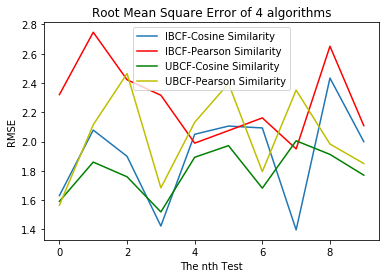

,0,1,2,3,4,5,6,7,8,9
IC,1.630340,2.078065,1.898707,1.422406,2.049424,2.105369,2.092736,1.395869,2.433741,1.998973
IP,2.320506,2.746608,2.421888,2.316137,1.988851,2.074422,2.161363,1.949467,2.650869,2.108321
UC,1.591020,1.859321,1.758902,1.518717,1.892265,1.971638,1.681229,2.004781,1.912020,1.770000
UP,1.564611,2.114413,2.464116,1.683320,2.131351,2.395871,1.794736,2.351022,1.982741,1.849519


In [18]:

# x_date = [datestr2num(i) for i in data.index]
x = range(len(resultOfError.columns))
plt.title("Root Mean Square Error of 4 algorithms")
plt.xlabel("The nth Test")
plt.ylabel("RMSE")
plt.plot(x,resultOfError.loc['IC'],label="IBCF-Cosine Similarity")
plt.plot(x,resultOfError.loc['IP'],color='r', label="IBCF-Pearson Similarity")
plt.plot(x,resultOfError.loc['UC'],color='g', label="UBCF-Cosine Similarity")
plt.plot(x,resultOfError.loc['UP'],color='y', label="UBCF-Pearson Similarity")

plt.legend()
plt.show()
resultOfError
